# Project Notebook

### Imports

In [1]:
import numpy as np
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, LeakyReLU, Add, Input
from tensorflow.keras.models import Model
from tensorflow.nn import depth_to_space
from matplotlib import pyplot as plt

2022-04-19 15:28:55.002254: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-19 15:28:55.002406: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Path & Data

In [2]:
PATH_DATA = "./Data"
PATH_SAVE = "./Save"

In [8]:
data = PATH_DATA+"/1308_square_NATL60_SSH_R09.npy"
ssh = np.load(data)

(488, 144, 144)

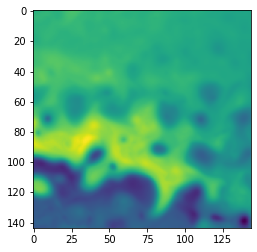

In [11]:
plt.imshow(ssh[0])
ssh_train = ssh[0:366,:,:]
ssh_test = ssh[366:, :, :]

In [3]:
test=np.load(PATH_DATA+"/natl60_htuv_03_06_09_12-2008.npz", "r")
train=np.load(PATH_DATA+"/natl60_htuv_01102012_01102013.npz", "r")  

In [4]:
test_ssh_r01=test["FdataAllVar"][0,:,:,0:1296]

In [5]:
test_sst_r01=test["FdataAllVar"][1,:,:,0:1296]

In [6]:
train_ssh_r01=train["FdataAllVar"][0,:,:,0:1296]
train_sst_r01=train["FdataAllVar"][1,:,:,0:1296]

MemoryError: Unable to allocate 9.73 GiB for an array with shape (2612642688,) and data type float32

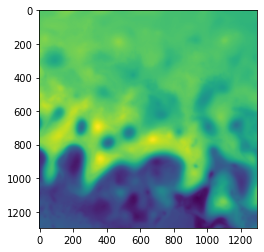

In [124]:
plt.imshow(test_ssh_r01[0])

### Model

In [5]:
filters = 64
upscale_factor = 2

In [6]:
def simple_conv_model( shape=1, filters=filters ):
    ''' extracts SST features '''
    input_img = Input(shape=(None, None, shape))
    x = Conv2D(filters, (3,3), padding='same')(input_img)
    x = LeakyReLU(alpha=0.2)(x)        
    x = Conv2D(filters, (3,3), padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    return Model(inputs=input_img, outputs=x)

In [7]:
def shuffle_model( filters=filters ):
    ''' upsamples in feature branch '''
    input_img = Input(shape=(None, None, filters))
    x = Conv2D(filters, (3,3), padding='same')(input_img)
    x = depth_to_space(x, upscale_factor)        
    x = Conv2D(filters, (2,2), padding='same')(x)
    x = LeakyReLU()(x)
    return Model(inputs=input_img, outputs=x)

In [8]:
def upsample_model( shape=1, filters=filters ):
    ''' upsamples SSH '''
    input_img = Input(shape=(None, None, shape))
    upsample = Conv2DTranspose(filters, (4,4), strides=(2,2), padding='same')(input_img)
    return Model(inputs=input_img, outputs=upsample)

In [12]:
def net():
    simple_conv_1 = simple_conv_model(1)
    simple_conv_2 = simple_conv_model(filters)
    shuffle = shuffle_model()
    #upsample_1 = upsample_1_model()
    upsample_1 = upsample_model(1)
    upsample_2 = upsample_model(filters)
    
    input_hr = Input(shape=(None, None, 1))
    input_lr = Input(shape=(None, None, 1))
    
    # firstPass
    x = simple_conv_1(input_hr)
    y = upsample_1(input_lr)
    hr = Add()([y, x])
    # secondPass
    x = shuffle(x)
    x = simple_conv_2(x)
    y = upsample_2(hr)
    hr = Add()([y, x])
    
    return Model(inputs=[input_lr, input_hr], outputs=hr)

### Train the model

In [13]:
loss = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(learning_rate=0.001)

In [14]:
model = net()
model.compile(optimizer=optimizer, loss=loss)